In [1]:
!pip install mxnet gluoncv

In [2]:
# Linear Regression from scratch.
import mxnet as mx
from mxnet import autograd, np, npx
import random
npx.set_np()

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.matmul(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, np.reshape(y, (-1, 1))

In [4]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features.shape)
print(labels.shape)

(1000, 2)
(1000, 1)


In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: [2.2122064 1.1630787] 
label: [4.662078]


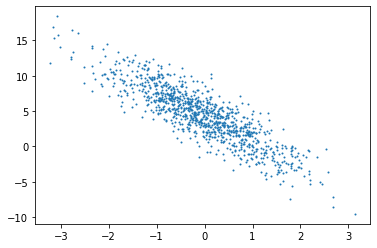

In [6]:
import matplotlib.pyplot as plt

# The semicolon is for displaying the plot only
plt.scatter((features[:, 1]), (labels), 1);

In [7]:
def data_iter(batch_size, features, labels):
  # N = num samples.
  num_examples = len(features)
  indices = list(range(num_examples))

  # The examples are read at random, in no particular order
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = np.array(
    indices[i: min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

In [8]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X.shape, y.shape)
  break

(10, 2) (10, 1)


In [9]:
w = np.random.normal(0, 0.01, (2, 1))
b = np.zeros(1)
w.attach_grad()
b.attach_grad()

In [10]:
def linreg(X, w, b):
  """The linear regression model."""
  return np.dot(X, w) + b

In [11]:
def squared_loss(y_hat, y):
  """Squared loss."""
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [12]:
def sgd(params, lr, batch_size): #@save
  """Minibatch stochastic gradient descent."""
  for param in params:
    param[:] = param - lr * param.grad / batch_size

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [14]:
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    with autograd.record():
      l = loss(net(X, w, b), y) # Minibatch loss in `X` and `y`
    # Because `l` has a shape (`batch_size`, 1) and is not a scalar
    # variable, the elements in `l` are added together to obtain a new
    # variable, on which gradients with respect to [`w`, `b`] are computed
    l.backward()
    sgd([w, b], lr, batch_size) # Update parameters using their gradient
  train_l = loss(net(features, w, b), labels)
  print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.025014
epoch 2, loss 0.000086
epoch 3, loss 0.000051


In [15]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [ 0.0005827  -0.00011063]
error in estimating b: [0.00076723]


In [16]:
# Linear Regression with gloun
import mxnet as mx
from mxnet import autograd, gluon, np, npx
npx.set_np()

In [17]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features.shape)
print(labels.shape)

(1000, 2)
(1000, 1)


In [18]:
def load_array(data_arrays, batch_size, is_train=True): #@save
  """Construct a Gluon data iterator."""
  dataset = gluon.data.ArrayDataset(*data_arrays)
  return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [19]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [20]:
# the result is an iterator
next(iter(data_iter))

[array([[ 0.73805815, -0.40662253],
        [-1.0053293 ,  0.6025365 ],
        [ 0.92937523, -1.9473807 ],
        [ 1.1349536 , -0.59669524],
        [-0.47798645, -0.2504528 ],
        [-0.2952682 , -1.5392796 ],
        [-1.0387986 , -1.450659  ],
        [-0.90060335, -0.43511948],
        [ 0.6525416 ,  0.22451855],
        [-0.08192009, -0.7493096 ]]), array([[ 7.07397   ],
        [ 0.13816382],
        [12.664182  ],
        [ 8.484783  ],
        [ 4.085835  ],
        [ 8.849043  ],
        [ 7.0641456 ],
        [ 3.8683429 ],
        [ 4.743528  ],
        [ 6.586482  ]])]

In [21]:
# `nn` is an abbreviation for neural networks
from mxnet.gluon import nn
net = nn.Sequential()
net.add(nn.Dense(1))

In [22]:
from mxnet import init
net.initialize(init.Normal(sigma=0.01))

In [23]:
loss = gluon.loss.L2Loss()

In [24]:
from mxnet import gluon
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

In [25]:
num_epochs = 3
for epoch in range(num_epochs):
  for X, y in data_iter:
    with autograd.record():
      l = loss(net(X), y)
    l.backward()
    trainer.step(batch_size)
  l = loss(net(features), labels)
  print(f'epoch {epoch + 1}, loss {l.mean().asnumpy():f}')

epoch 1, loss 0.042368
epoch 2, loss 0.000167
epoch 3, loss 0.000050
